# Eigenfaces a

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from numpy.linalg import matrix_rank
from numpy.linalg import inv
import time

mat_content = sio.loadmat('face.mat')

face_data = mat_content['X']
face_id = mat_content['l']

print(face_data)
print(face_data.shape)

print(face_id)
print(face_id.shape)

[[106 130 191 ...  70 183  77]
 [103 129 185 ...  62 250  72]
 [103 130 174 ...  83 163  68]
 ...
 [ 37  40  22 ...  87 102  93]
 [ 36  36  19 ...  89  95 103]
 [ 41  35  17 ...  94 106 110]]
(2576, 520)
[[ 1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  3  3  3  3
   3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5
   5  5  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  8  8
   8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
  10 10 10 10 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12
  13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 15 15 15 15
  15 15 15 15 15 15 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17
  17 17 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 20 20
  20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21 21 21 22 22 22 22 22 22
  22 22 22 22 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24
  25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 

In [2]:
# Split data set
# Train_id is the index of each train data in the total data set, test_id the same

from sklearn.model_selection import train_test_split

indices = np.arange(len(face_id[0]))
train_data, test_data, train_id, test_id = train_test_split(face_data.T, indices, test_size = 0.1)
train_data = train_data.T
test_data = test_data.T

print(train_data)
print(train_data.shape)
print(test_data)
print(test_data.shape)

[[226  91 116 ...  93 142 238]
 [203  90 116 ...  95  91 247]
 [214  92 119 ...  92  97 244]
 ...
 [ 63 105  39 ...  24  74 143]
 [ 80 111  39 ...  23  51 143]
 [ 65 112  40 ...  21  35 133]]
(2576, 468)
[[ 93  61  67 ... 199 168 149]
 [ 94  64  61 ... 211 163 147]
 [ 68  64  65 ... 216 168 142]
 ...
 [175  71  32 ...  30  28  98]
 [171  60  25 ...  27  27  89]
 [160  49  25 ...  25  28  82]]
(2576, 52)


In [3]:
# Count the number of face images for each person 
# in the train and test set after randomly split

train_label = face_id[0,train_id]
unique_train, counts_train = np.unique(train_label, return_counts=True)
dict(zip(unique_train, counts_train))

#test_label = face_id[0,test_id]
#unique_test, counts_test = np.unique(test_label, return_counts=True)
#dict(zip(unique_test, counts_test))

#print(unique_train)
#print(train_label)
#print(counts_train)


{1: 9,
 2: 9,
 3: 10,
 4: 10,
 5: 9,
 6: 10,
 7: 10,
 8: 10,
 9: 9,
 10: 10,
 11: 9,
 12: 8,
 13: 9,
 14: 7,
 15: 10,
 16: 9,
 17: 8,
 18: 10,
 19: 10,
 20: 9,
 21: 8,
 22: 9,
 23: 9,
 24: 7,
 25: 10,
 26: 8,
 27: 9,
 28: 10,
 29: 10,
 30: 8,
 31: 7,
 32: 9,
 33: 7,
 34: 10,
 35: 8,
 36: 9,
 37: 9,
 38: 10,
 39: 10,
 40: 10,
 41: 9,
 42: 10,
 43: 9,
 44: 8,
 45: 9,
 46: 9,
 47: 8,
 48: 10,
 49: 8,
 50: 10,
 51: 8,
 52: 8}

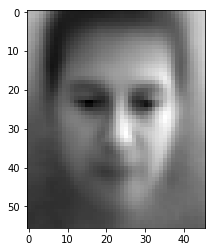

In [4]:
# Compute average face vector

num_train = len(train_data[0])

avg_face = train_data.mean(axis=1)

plt.imshow(np.reshape(avg_face,(46,56)).T, cmap = 'gist_gray')

#print(train_data.shape)
#print(num_train)

In [5]:
# Compute covariance matrix without low-dimensional compution

num_pix = len(train_data)

A = train_data - avg_face.reshape(num_pix,1)
S = (A.dot(A.T)) / num_train

#print(num_pix)

# PCA-LDA Ensemble 

In [6]:
import random

T = 3
M0 = 200
M1 = 10
# Mpca = M0 + M1 should not exceed 
M_lda = 50
n_sample = 7 # number of samples per class
M_pca = 200

# Generate random subspaces 
def rand_subspace(eigvecs,eigvals):
    subspace = eigvecs[:,np.argsort(-eigvals)[ : M0]]
    #print(len(eigvals))
    index = (np.argsort(eigvals)[ : len(eigvals) - M0]).tolist()
    rand_index = random.sample(index, M1)  
    subspace = np.concatenate((subspace, eigvecs[:,rand_index]), axis=1)
    return subspace

# Bagging (from every class)
def rand_sample(sorted_train_data,sorted_train_label,counts_train):
    sample = list()
    label = list()
    current_index = 0
    for idx,cnt in enumerate(counts_train):
        for j in range(n_sample):
            index = random.randrange(current_index, current_index + cnt, 1)
            sample.append(sorted_train_data[:,index])
            label.append(sorted_train_label[index])
        current_index += cnt
    
    return ((np.asarray(sample)).T), np.asarray(label)

# Generate eigenspace of data set using PCA
def eigspace_generator_ensemble(data):
    num_train = len(data[0])
    avg_face = data.mean(axis=1)
    num_pix = len(data)
    A = data - avg_face.reshape(num_pix,1)
    S_low_dim = ((A.T).dot(A)) / num_train
    eigvals_low_dim, eigvecs_low_dim = np.linalg.eig(S_low_dim)
    eigvals_low_dim = eigvals_low_dim.real
    eigvecs_low_dim = eigvecs_low_dim.real
    nonzero_eigvals_low_dim = eigvals_low_dim[abs(eigvals_low_dim) >= 1e-7]
    eigvecs_nonzero_eigvals_low_dim = eigvecs_low_dim[:,abs(eigvals_low_dim) >= 1e-7]
    eigfaces_low_dim_unnormalized = A.dot(eigvecs_nonzero_eigvals_low_dim[:,np.argsort(-nonzero_eigvals_low_dim)[:M_pca]]) 
    eigfaces_low_dim = (preprocessing.normalize(eigfaces_low_dim_unnormalized.T, norm='l2')).T
    return eigfaces_low_dim, nonzero_eigvals_low_dim, A


# Committe Machine with Bagging

In [7]:
sorted_train_data = train_data[:,np.argsort(train_label)]
sorted_train_label = train_label[np.argsort(train_label)]

In [8]:
def lda_rand_data(train_data,train_label,test_data): # test_data single column vector

    avg_face = train_data.mean(axis=1)
    num_pix = len(train_data)
    unique_train, counts_train = np.unique(train_label, return_counts=True)
    c = max(train_label) # number of classes
    M = np.zeros((num_pix, c))

    list_Sw = [] # Each element of list_Sw contains the with-in scatter matrix of the i+1th class
    
    current_index = 0;
    for idx in range(c):
        X = train_data[:,current_index : current_index + n_sample]
        M[:,idx] = (X.mean(axis=1))
        A_Sw =  X - M[:,idx].reshape(num_pix,1)
        Sw = A_Sw.dot(A_Sw.T)
        list_Sw.append(Sw)
        current_index += n_sample
    
    # Compute between-scatter matrix Sb

    A_Sb =  M - avg_face.reshape(num_pix,1)
    Sb = A_Sb.dot(A_Sb.T)

    # Compute within-scatter matrix Sw
    Sw = np.zeros((num_pix,num_pix))

    for i in range(c):
        Sw += list_Sw[i]

    # PCA to reduce dimenstion to Mpca
    
    W_pca, eigenvalues, A = eigspace_generator_ensemble(train_data)
    
    Sb_pca = (W_pca.T).dot(Sb.dot(W_pca))
    Sw_pca = (W_pca.T).dot(Sw.dot(W_pca))
    
    eigvals_lda, eigvecs_lda = np.linalg.eig((inv(Sw_pca)).dot(Sb_pca))
    eigvals_lda = eigvals_lda.real
    eigvecs_lda = eigvecs_lda.real

    nonzero_eigvals_lda = eigvals_lda[abs(eigvals_lda) >= 1e-7]
    eigvecs_nonzero_eigvals_lda = eigvecs_lda[:,abs(eigvals_lda) >= 1e-7]
    
    sorted_index_lda = np.argsort(-nonzero_eigvals_lda)[:M_lda]

    W_lda = eigvecs_nonzero_eigvals_lda[:,sorted_index_lda]

    # NN-classification

    W_train_pca = (A.T).dot(W_pca)
    W_train_lda = (W_train_pca).dot(W_lda)
    sorted_W_train_lda = W_train_lda[np.argsort(train_label),:]

    A_test_lda = test_data.reshape(num_pix,1) - avg_face.reshape(num_pix,1)

    # Project test data to PCA subspace
    W_test_pca = (A_test_lda.T).dot(W_pca) # Coordinates (row vector) on PCA subspace
    # Project test data to LDA subspace
    W_test_lda = (W_test_pca).dot(W_lda) # Coordinates (row vector) on LDA subspace
    
    distance = np.linalg.norm(W_test_lda - sorted_W_train_lda, axis=1) # row vector containing Euclidiean distance to each tranining data
   
        
    min_distance = []
    current_index = 0;
    for idx,cnt in enumerate(counts_train):
        distance = distance.reshape(len(distance),1)
        min_distance.append(min(distance[current_index : current_index + cnt,:]))
        current_index += cnt
    
    post_distribution = (min_distance / sum(min_distance)) 
    
    return post_distribution

In [9]:
true_results = face_id[0,test_id]
print(true_results)

[24 31 21 30 43 14 22 24 44 33 52 32 47  2 14 31 51 12 23 13  5 51 26 41
 17 35 49 31 47 35 21 30 37 33  1 27 12 20 36 46 33 26 17 16 49 52  9 14
 45 11 44 24]


In [10]:
S = []
S_label = []

for i in range(T):
    data,label = rand_sample(sorted_train_data,sorted_train_label,counts_train)
    S.append(data) # generate T random training subset
    S_label.append(label)

    
test_results_ensemble = []
for i in range(len(test_data[0])):
    post_distribution = [] # each column vector contains posterior distribution of each model
    
    for j in range(T):
        post_distribution.append(lda_rand_data(S[j],S_label[j],test_data[:,i])) # perform lda on each subspaces learnt

    index = np.argmin(sum(post_distribution) / (T)) + 1
    test_results_ensemble.append(index)
    print(test_results_ensemble)
    
print(test_results_ensemble)

[19]
[19, 31]
[19, 31, 21]
[19, 31, 21, 30]
[19, 31, 21, 30, 43]
[19, 31, 21, 30, 43, 14]
[19, 31, 21, 30, 43, 14, 19]
[19, 31, 21, 30, 43, 14, 19, 24]
[19, 31, 21, 30, 43, 14, 19, 24, 21]
[19, 31, 21, 30, 43, 14, 19, 24, 21, 33]
[19, 31, 21, 30, 43, 14, 19, 24, 21, 33, 38]
[19, 31, 21, 30, 43, 14, 19, 24, 21, 33, 38, 32]
[19, 31, 21, 30, 43, 14, 19, 24, 21, 33, 38, 32, 38]
[19, 31, 21, 30, 43, 14, 19, 24, 21, 33, 38, 32, 38, 30]
[19, 31, 21, 30, 43, 14, 19, 24, 21, 33, 38, 32, 38, 30, 14]
[19, 31, 21, 30, 43, 14, 19, 24, 21, 33, 38, 32, 38, 30, 14, 31]
[19, 31, 21, 30, 43, 14, 19, 24, 21, 33, 38, 32, 38, 30, 14, 31, 51]
[19, 31, 21, 30, 43, 14, 19, 24, 21, 33, 38, 32, 38, 30, 14, 31, 51, 12]
[19, 31, 21, 30, 43, 14, 19, 24, 21, 33, 38, 32, 38, 30, 14, 31, 51, 12, 23]
[19, 31, 21, 30, 43, 14, 19, 24, 21, 33, 38, 32, 38, 30, 14, 31, 51, 12, 23, 13]
[19, 31, 21, 30, 43, 14, 19, 24, 21, 33, 38, 32, 38, 30, 14, 31, 51, 12, 23, 13, 5]
[19, 31, 21, 30, 43, 14, 19, 24, 21, 33, 38, 32, 38, 30,

In [ ]:
results_error = test_results_ensemble - true_results

success_rate = np.count_nonzero(results_error == 0) / len(results_error)
print(success_rate)